1. Download/Load NIFTY stocks prices data.

In [20]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import sklearn
warnings.filterwarnings('ignore')

ysymbol=['ADANIENT.NS',
'ADANIPORTS.NS',
'APOLLOHOSP.NS',
'ASIANPAINT.NS',
'AXISBANK.NS',
'BAJAJ-AUTO.NS',
'BAJFINANCE.NS',
'BAJAJFINSV.NS',
'BPCL.NS',
'BHARTIARTL.NS',
'BRITANNIA.NS',
'CIPLA.NS',
'COALINDIA.NS',
'DIVISLAB.NS',
'DRREDDY.NS',
'EICHERMOT.NS',
'GRASIM.NS',
'HCLTECH.NS',
'HDFCBANK.NS',
'HDFCLIFE.NS',
'HEROMOTOCO.NS',
'HINDALCO.NS',
'HINDUNILVR.NS',
'ICICIBANK.NS',
'ITC.NS',
'INDUSINDBK.NS',
'INFY.NS',
'JSWSTEEL.NS',
'KOTAKBANK.NS',
'LTIM.NS',
'LT.NS',
'M&M.NS',
'MARUTI.NS',
'NTPC.NS',
'NESTLEIND.NS',
'ONGC.NS',
'POWERGRID.NS',
'RELIANCE.NS',
'SBILIFE.NS',
'SBIN.NS',
'SUNPHARMA.NS',
'TCS.NS',
'TATACONSUM.NS',
'TATAMOTORS.NS',
'TATASTEEL.NS',
'TECHM.NS',
'TITAN.NS',
'UPL.NS',
'ULTRACEMCO.NS',
'WIPRO.NS']

# Yahoo finance takes nse stocks ending with .ns



end_date = dt.date.today()
# data fro previous 8 years
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=ysymbol,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df


[*********************100%%**********************]  50 of 50 completed


adj close         close          high  \
date       ticker                                                    
2016-04-07 ADANIENT.NS       40.470303     41.303513     42.066376   
           ADANIPORTS.NS    208.211517    216.800003    228.000000   
           APOLLOHOSP.NS   1321.203369   1354.500000   1372.099976   
           ASIANPAINT.NS    812.941528    858.250000    869.000000   
           AXISBANK.NS      417.004578    426.649994    431.799988   
...                                ...           ...           ...   
2024-04-04 SBILIFE.NS      1463.750000   1463.750000   1475.050049   
           SUNPHARMA.NS    1619.349976   1619.349976   1628.000000   
           TECHM.NS        1279.250000   1279.250000   1289.000000   
           TITAN.NS        3782.750000   3782.750000   3792.300049   
           ULTRACEMCO.NS  10005.099609  10005.099609  10078.900391   

                                  low          open     volume  
date       ticker                                               
2016-04-07 ADANIENT.NS      40.840347     41.684944  8449410.0  
           ADANIPORTS.NS   216.000000    225.500000  4171133.0  
           APOLLOHOSP.NS  1346.400024   1350.000000   108498.0  
           ASIANPAINT.NS   855.049988    864.000000   449770.0  
           AXISBANK.NS     424.899994    427.750000  5374072.0  
...                               ...           ...        ...  
2024-04-04 SBILIFE.NS     1447.000000   1467.500000  1905528.0  
           SUNPHARMA.NS   1587.150024   1620.900024  2439461.0  
           TECHM.NS       1246.900024   1260.000000  2460669.0  
           TITAN.NS       3679.000000   3740.000000  1177617.0  
           ULTRACEMCO.NS  9900.000000  10078.000000   346378.0  

[97829 rows x 6 columns]

2. Calculate features and technical indicators for each stock.
Garman-Klass Volatility
RSI
Bollinger Bands
ATR
MACD
Nifty Rupees Volume

In [21]:
df['garman_klass_vol']=((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

#pandas_ta  is a library that leverages the Pandas package with more than 130 Indicators and Utility functions and more than 60 TA Lib Candlestick Patterns. 
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
#The rupees  volume is the total value of the shares traded. the value is in lakhs 
df['rupees_volume'] = (df['adj close'] * df['volume']) / 1e5

df

adj close         close          high  \
date       ticker                                                    
2016-04-07 ADANIENT.NS       40.470303     41.303513     42.066376   
           ADANIPORTS.NS    208.211517    216.800003    228.000000   
           APOLLOHOSP.NS   1321.203369   1354.500000   1372.099976   
           ASIANPAINT.NS    812.941528    858.250000    869.000000   
           AXISBANK.NS      417.004578    426.649994    431.799988   
...                                ...           ...           ...   
2024-04-04 SBILIFE.NS      1463.750000   1463.750000   1475.050049   
           SUNPHARMA.NS    1619.349976   1619.349976   1628.000000   
           TECHM.NS        1279.250000   1279.250000   1289.000000   
           TITAN.NS        3782.750000   3782.750000   3792.300049   
           ULTRACEMCO.NS  10005.099609  10005.099609  10078.900391   

                                  low          open     volume  \
date       ticker                                                
2016-04-07 ADANIENT.NS      40.840347     41.684944  8449410.0   
           ADANIPORTS.NS   216.000000    225.500000  4171133.0   
           APOLLOHOSP.NS  1346.400024   1350.000000   108498.0   
           ASIANPAINT.NS   855.049988    864.000000   449770.0   
           AXISBANK.NS     424.899994    427.750000  5374072.0   
...                               ...           ...        ...   
2024-04-04 SBILIFE.NS     1447.000000   1467.500000  1905528.0   
           SUNPHARMA.NS   1587.150024   1620.900024  2439461.0   
           TECHM.NS       1246.900024   1260.000000  2460669.0   
           TITAN.NS       3679.000000   3740.000000  1177617.0   
           ULTRACEMCO.NS  9900.000000  10078.000000   346378.0   

                          garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2016-04-07 ADANIENT.NS        9.963042e-05        NaN       NaN       NaN   
           ADANIPORTS.NS     -9.961906e-04        NaN       NaN       NaN   
           APOLLOHOSP.NS     -8.332347e-07        NaN       NaN       NaN   
           ASIANPAINT.NS     -1.302384e-03        NaN       NaN       NaN   
           AXISBANK.NS       -1.202965e-04        NaN       NaN       NaN   
...                                    ...        ...       ...       ...   
2024-04-04 SBILIFE.NS         1.817810e-04  47.244619  7.279382  7.306263   
           SUNPHARMA.NS       3.225388e-04  64.458717  7.338395  7.371835   
           TECHM.NS           4.625203e-04  50.421898  7.120187  7.146383   
           TITAN.NS           4.101063e-04  56.310372  8.176848  8.217279   
           ULTRACEMCO.NS      1.400134e-04  56.001551  9.146852  9.180838   

                           bb_high       atr      macd  rupees_volume  
date       ticker                                                      
2016-04-07 ADANIENT.NS         NaN       NaN       NaN    3419.501793  
           ADANIPORTS.NS       NaN       NaN       NaN    8684.779309  
           APOLLOHOSP.NS       NaN       NaN       NaN    1433.479231  
           ASIANPAINT.NS       NaN       NaN       NaN    3656.367112  
           AXISBANK.NS         NaN       NaN       NaN   22410.126245  
...                            ...       ...       ...            ...  
2024-04-04 SBILIFE.NS     7.333145  1.096286 -0.503830   27892.166100  
           SUNPHARMA.NS   7.405276  3.441105  1.797707   39503.411108  
           TECHM.NS       7.172580  0.325957 -0.729774   31478.108183  
           TITAN.NS       8.257709  2.090945  0.329729   44546.307067  
           ULTRACEMCO.NS  9.214825  1.667815  0.027220   34655.463925  

[97829 rows x 14 columns]

3. Aggregate to monthly level and filter most liquid stocks for each month.
To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [22]:
last_cols = [c for c in df.columns.unique(0) if c not in ['rupees_volume', 'volume', 'open','high', 'low', 'close']]
data = (pd.concat([df.unstack('ticker')['rupees_volume'].resample('M').mean().stack('ticker').to_frame('rupees_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

rupees_volume     adj close  garman_klass_vol  \
date       ticker                                                         
2016-05-31 ADANIENT.NS      2187.216331     38.895264         -0.000033   
           ADANIPORTS.NS   16635.125580    184.538010          0.000555   
           APOLLOHOSP.NS    2888.331404   1335.444336         -0.000084   
           ASIANPAINT.NS   10971.282022    932.858398         -0.001162   
           AXISBANK.NS     40386.404955    503.552673         -0.000074   
...                                 ...           ...               ...   
2024-04-30 TECHM.NS        22006.863776   1279.250000          0.000463   
           TITAN.NS        33952.453547   3782.750000          0.000410   
           ULTRACEMCO.NS   38061.428074  10005.099609          0.000140   
           UPL.NS          20839.009277    476.700012          0.000336   
           WIPRO.NS        21551.817321    483.200012          0.000280   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-05-31 ADANIENT.NS    44.062071  3.631119  3.702670  3.774221 -0.759951   
           ADANIPORTS.NS  43.156087  5.118457  5.204383  5.290309 -0.978557   
           APOLLOHOSP.NS  54.954842  7.139597  7.174483  7.209369 -0.867232   
           ASIANPAINT.NS  69.683662  6.711305  6.794988  6.878671 -1.225932   
           AXISBANK.NS    68.056538  6.108947  6.177241  6.245535 -0.960346   
...                             ...       ...       ...       ...       ...   
2024-04-30 TECHM.NS       50.421898  7.120187  7.146383  7.172580  0.325957   
           TITAN.NS       56.310372  8.176848  8.217279  8.257709  2.090945   
           ULTRACEMCO.NS  56.001551  9.146852  9.180838  9.214825  1.667815   
           UPL.NS         47.812302  6.111177  6.149026  6.186876 -0.774581   
           WIPRO.NS       44.442308  6.153869  6.215622  6.277374  1.104709   

                              macd  
date       ticker                   
2016-05-31 ADANIENT.NS   -0.182290  
           ADANIPORTS.NS -0.932730  
           APOLLOHOSP.NS -0.158685  
           ASIANPAINT.NS  0.599226  
           AXISBANK.NS    0.882971  
...                            ...  
2024-04-30 TECHM.NS      -0.729774  
           TITAN.NS       0.329729  
           ULTRACEMCO.NS  0.027220  
           UPL.NS        -0.506533  
           WIPRO.NS      -1.121809  

[4760 rows x 9 columns]

Calculate 5-year rolling average of rupees volume for each stocks before filtering.


In [23]:
data['rupees_volume'] = (data.loc[:, 'rupees_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['rupees_vol_rank'] = (data.groupby('date')['rupees_volume'].rank(ascending=False))
data = data[data['rupees_vol_rank']<12].drop(['rupees_volume', 'rupees_vol_rank'], axis=1)
# we are selecting top 12 stocks for our portfolio

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2017-04-30 AXISBANK.NS     502.786194          0.000178  53.415714  6.176689   
           HDFCBANK.NS     736.502380         -0.001161  73.350282  6.491661   
           ICICIBANK.NS    245.249603          0.000204  51.117150  5.470797   
           INFY.NS         387.185791         -0.012398  36.584158  5.921209   
           LT.NS          1036.837158         -0.005969  71.275172  6.847335   
...                               ...               ...        ...       ...   
2024-04-30 RELIANCE.NS    2943.199951          0.000036  54.406716  7.945430   
           SBIN.NS         771.049988          0.000107  61.640166  6.575961   
           TATAMOTORS.NS  1009.150024          0.000228  61.978575  6.843070   
           TATASTEEL.NS    163.649994          0.000169  65.683779  4.949852   
           TCS.NS         3947.300049          0.000315  47.623796  8.240322   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2017-04-30 AXISBANK.NS    6.210429  6.244168 -0.669752 -0.035889  
           HDFCBANK.NS    6.553383  6.615105 -0.925533  0.768303  
           ICICIBANK.NS   5.506508  5.542220 -1.355129 -0.393124  
           INFY.NS        5.998413  6.075616 -1.228925 -0.741672  
           LT.NS          6.908380  6.969424 -1.145310  0.674229  
...                            ...       ...       ...       ...  
2024-04-30 RELIANCE.NS    7.982636  8.019842  0.832286  0.210371  
           SBIN.NS        6.626726  6.677492  1.992931  0.665912  
           TATAMOTORS.NS  6.897157  6.951245  3.568772  1.252891  
           TATASTEEL.NS   5.031544  5.113235  2.200431  2.206187  
           TCS.NS         8.299877  8.359431  1.844630 -1.448716  

[935 rows x 8 columns]

4. Calculate Monthly Returns for different time horizons as features.
To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [24]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2018-04-30 AXISBANK.NS     515.347229          0.000351  48.656787  6.176233   
           HDFCBANK.NS     932.102600         -0.000375  56.051339  6.814284   
           ICICIBANK.NS    277.459564         -0.000175  46.382591  5.581742   
           INFY.NS         520.302368         -0.005984  59.057889  6.167541   
           MARUTI.NS      8352.067383         -0.000876  43.677068  9.029540   
...                               ...               ...        ...       ...   
2024-04-30 RELIANCE.NS    2943.199951          0.000036  54.406716  7.945430   
           SBIN.NS         771.049988          0.000107  61.640166  6.575961   
           TATAMOTORS.NS  1009.150024          0.000228  61.978575  6.843070   
           TATASTEEL.NS    163.649994          0.000169  65.683779  4.949852   
           TCS.NS         3947.300049          0.000315  47.623796  8.240322   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2018-04-30 AXISBANK.NS    6.247965  6.319697  0.100316 -0.354919   0.013320   
           HDFCBANK.NS    6.830372  6.846461 -0.720567  0.123349   0.030857   
           ICICIBANK.NS   5.625122  5.668502 -0.835154 -0.553023   0.021017   
           INFY.NS        6.213206  6.258870 -0.701747  0.015440   0.059816   
           MARUTI.NS      9.060989  9.092438 -0.239150 -0.354361  -0.005208   
...                            ...       ...       ...       ...        ...   
2024-04-30 RELIANCE.NS    7.982636  8.019842  0.832286  0.210371  -0.009590   
           SBIN.NS        6.626726  6.677492  1.992931  0.665912   0.024855   
           TATAMOTORS.NS  6.897157  6.951245  3.568772  1.252891   0.016469   
           TATASTEEL.NS   5.031544  5.113235  2.200431  2.206187   0.050048   
           TCS.NS         8.299877  8.359431  1.844630 -1.448716   0.018316   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2018-04-30 AXISBANK.NS    -0.010887  -0.044825  -0.001872  -0.000536   
           HDFCBANK.NS     0.015823  -0.010310   0.012140   0.009581   
           ICICIBANK.NS   -0.047497  -0.069670  -0.009032  -0.006946   
           INFY.NS         0.011405   0.014073   0.044857   0.020727   
           MARUTI.NS      -0.002036  -0.024971   0.011894   0.015531   
...                             ...        ...        ...        ...   
2024-04-30 RELIANCE.NS     0.003690   0.010400   0.042871   0.016493   
           SBIN.NS         0.015223   0.063786   0.053017   0.024485   
           TATAMOTORS.NS   0.030553   0.045045   0.082076   0.051119   
           TATASTEEL.NS    0.077903   0.063765   0.054906   0.032096   
           TCS.NS         -0.018212   0.011345   0.027558   0.016826   

                          return_12m  
date       ticker                     
2018-04-30 AXISBANK.NS      0.002058  
           HDFCBANK.NS      0.019821  
           ICICIBANK.NS     0.010336  
           INFY.NS          0.024931  
           MARUTI.NS        0.026237  
...                              ...  
2024-04-30 RELIANCE.NS      0.023537  
           SBIN.NS          0.025905  
           TATAMOTORS.NS    0.063247  
           TATASTEEL.NS     0.038054  
           TCS.NS           0.018596  

[756 rows x 14 columns]

5. Download Fama-French Factors and Calculate Rolling Factor Betas.
We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [25]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2018-04-30 AXISBANK.NS    0.0028  0.0093  0.0054 -0.0242  0.0130   0.013320
           HDFCBANK.NS    0.0028  0.0093  0.0054 -0.0242  0.0130   0.030857
           ICICIBANK.NS   0.0028  0.0093  0.0054 -0.0242  0.0130   0.021017
           INFY.NS        0.0028  0.0093  0.0054 -0.0242  0.0130   0.059816
           MARUTI.NS      0.0028  0.0093  0.0054 -0.0242  0.0130  -0.005208
...                          ...     ...     ...     ...     ...        ...
2024-02-29 RELIANCE.NS    0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.023955
           SBIN.NS        0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.167994
           TATAMOTORS.NS  0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.074644
           TATASTEEL.NS   0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.036043
           TCS.NS         0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.073154

[734 rows x 6 columns]

Filter out stocks with less than 10 months of data.
this is done to prevent our regression function from breaking due to lack of data

In [26]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2018-04-30 AXISBANK.NS    0.0028  0.0093  0.0054 -0.0242  0.0130   0.013320
           HDFCBANK.NS    0.0028  0.0093  0.0054 -0.0242  0.0130   0.030857
           ICICIBANK.NS   0.0028  0.0093  0.0054 -0.0242  0.0130   0.021017
           INFY.NS        0.0028  0.0093  0.0054 -0.0242  0.0130   0.059816
           MARUTI.NS      0.0028  0.0093  0.0054 -0.0242  0.0130  -0.005208
...                          ...     ...     ...     ...     ...        ...
2024-02-29 RELIANCE.NS    0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.023955
           SBIN.NS        0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.167994
           TATAMOTORS.NS  0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.074644
           TATASTEEL.NS   0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.036043
           TCS.NS         0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.073154

[728 rows x 6 columns]

Calculate Rolling Factor Betas.


In [27]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2018-04-30 AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
           HDFCBANK.NS         NaN       NaN       NaN       NaN       NaN
           ICICIBANK.NS        NaN       NaN       NaN       NaN       NaN
           INFY.NS             NaN       NaN       NaN       NaN       NaN
           MARUTI.NS           NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2024-02-29 RELIANCE.NS    0.458076 -0.013317 -0.509745 -0.276028  1.240846
           SBIN.NS        0.389611  0.562437 -0.392771 -0.006989  0.692520
           TATAMOTORS.NS  0.964403 -0.111188  0.406290 -0.233849 -0.542854
           TATASTEEL.NS   0.961642  0.613269 -0.522870  0.047429  0.425152
           TCS.NS         0.524488  0.398353 -0.205723  0.005731  0.294585

[728 rows x 5 columns]

In [28]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis=1)

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 730 entries, (Timestamp('2018-04-30 00:00:00'), 'AXISBANK.NS') to (Timestamp('2024-04-30 00:00:00'), 'TCS.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  730 non-null    float64
 1   rsi               730 non-null    float64
 2   bb_low            730 non-null    float64
 3   bb_mid            730 non-null    float64
 4   bb_high           730 non-null    float64
 5   atr               730 non-null    float64
 6   macd              730 non-null    float64
 7   return_1m         730 non-null    float64
 8   return_2m         730 non-null    float64
 9   return_3m         730 non-null    float64
 10  return_6m         730 non-null    float64
 11  return_9m         730 non-null    float64
 12  return_12m        730 non-null    float64
 13  Mkt-RF            730 non-null    float64
 14  SMB               730 non-null    float64
 15  HM

Join the rolling factors data to the main features dataframe.


At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
K-Means Clustering
You may want to initialize predefined centroids for each cluster based on your research.

For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

Then we will pre-define our centroids for each cluster.

In [10]:
target_rsi_values = [30, 45, 55, 75]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [11]:
from sklearn.cluster import KMeans

#data=data.drop('cluster',axis=1)
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2018-04-30 AXISBANK.NS            0.000351  48.656787  6.176233  6.247965   
           HDFCBANK.NS           -0.000375  56.051339  6.814284  6.830372   
           ICICIBANK.NS          -0.000175  46.382591  5.581742  5.625122   
           INFY.NS               -0.005984  59.057889  6.167541  6.213206   
           MARUTI.NS             -0.000876  43.677068  9.029540  9.060989   
...                                    ...        ...       ...       ...   
2024-04-30 RELIANCE.NS            0.000036  54.406716  7.945430  7.982636   
           SBIN.NS                0.000107  61.640166  6.575961  6.626726   
           TATAMOTORS.NS          0.000228  61.978575  6.843070  6.897157   
           TATASTEEL.NS           0.000169  65.683779  4.949852  5.031544   
           TCS.NS                 0.000315  47.623796  8.240322  8.299877   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2018-04-30 AXISBANK.NS    6.319697  0.100316 -0.354919   0.013320  -0.010887   
           HDFCBANK.NS    6.846461 -0.720567  0.123349   0.030857   0.015823   
           ICICIBANK.NS   5.668502 -0.835154 -0.553023   0.021017  -0.047497   
           INFY.NS        6.258870 -0.701747  0.015440   0.059816   0.011405   
           MARUTI.NS      9.092438 -0.239150 -0.354361  -0.005208  -0.002036   
...                            ...       ...       ...        ...        ...   
2024-04-30 RELIANCE.NS    8.019842  0.832286  0.210371  -0.009590   0.003690   
           SBIN.NS        6.677492  1.992931  0.665912   0.024855   0.015223   
           TATAMOTORS.NS  6.951245  3.568772  1.252891   0.016469   0.030553   
           TATASTEEL.NS   5.113235  2.200431  2.206187   0.050048   0.077903   
           TCS.NS         8.359431  1.844630 -1.448716   0.018316  -0.018212   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2018-04-30 AXISBANK.NS    -0.044825  -0.001872  -0.000536    0.002058   
           HDFCBANK.NS    -0.010310   0.012140   0.009581    0.019821   
           ICICIBANK.NS   -0.069670  -0.009032  -0.006946    0.010336   
           INFY.NS         0.014073   0.044857   0.020727    0.024931   
           MARUTI.NS      -0.024971   0.011894   0.015531    0.026237   
...                             ...        ...        ...         ...   
2024-04-30 RELIANCE.NS     0.010400   0.042871   0.016493    0.023537   
           SBIN.NS         0.063786   0.053017   0.024485    0.025905   
           TATAMOTORS.NS   0.045045   0.082076   0.051119    0.063247   
           TATASTEEL.NS    0.063765   0.054906   0.032096    0.038054   
           TCS.NS          0.011345   0.027558   0.016826    0.018596   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2018-04-30 AXISBANK.NS    0.826714  0.297010  0.751446 -0.294905 -0.137773   
           HDFCBANK.NS    0.471460  0.554261  0.362835  0.232644 -0.069323   
           ICICIBANK.NS   0.717534 -0.201025  0.964499 -0.022920 -0.610650   
           INFY.NS        0.866122 -0.395074  0.052967 -0.854294  0.251555   
           MARUTI.NS      0.292775  0.735092  0.129584  1.806838  0.001171   
...                            ...       ...       ...       ...       ...   
2024-04-30 RELIANCE.NS    0.586411 -0.316148  0.126385 -0.049513  0.027951   
           SBIN.NS        0.610029 -0.149193  1.262961 -0.831851 -0.539777   
           TATAMOTORS.NS  1.447075  0.636136  0.641678  0.624752 -0.024079   
           TATASTEEL.NS   1.303773 -5.269795  1.699801  4.203902 -4.014238   
           TCS.NS         0.295967  0.363102 -0.165689  0.313438  0.290795   

                  

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

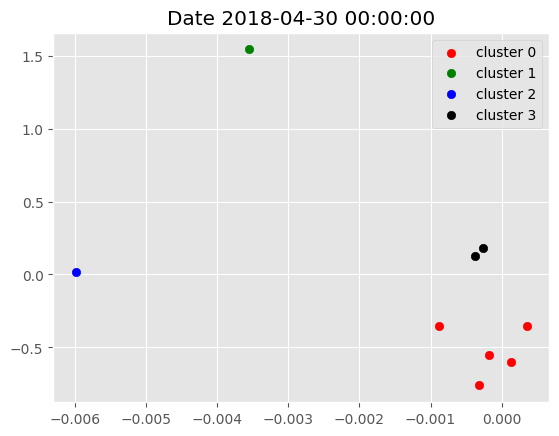

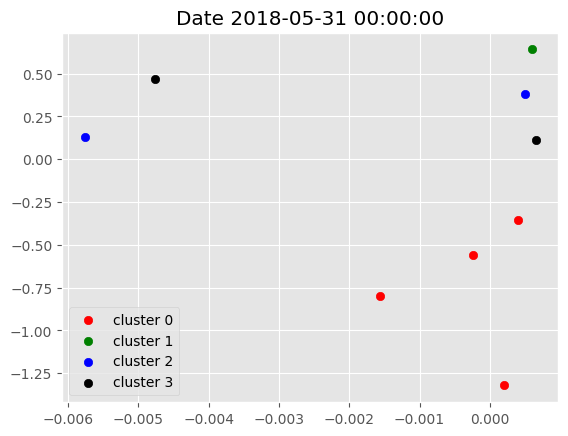

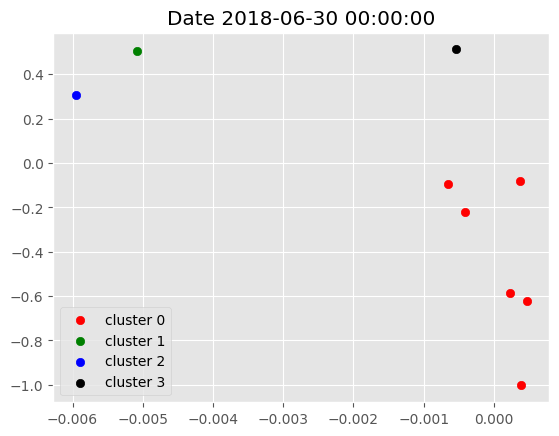

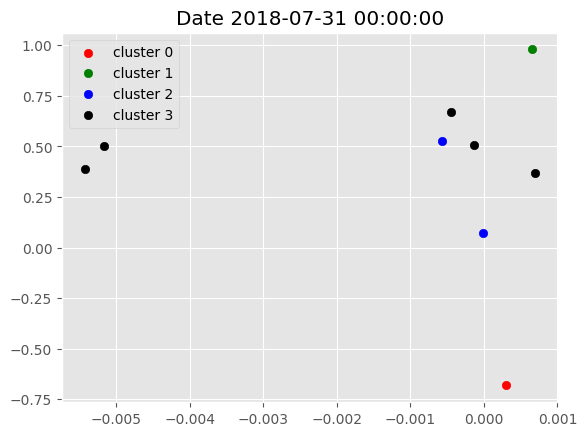

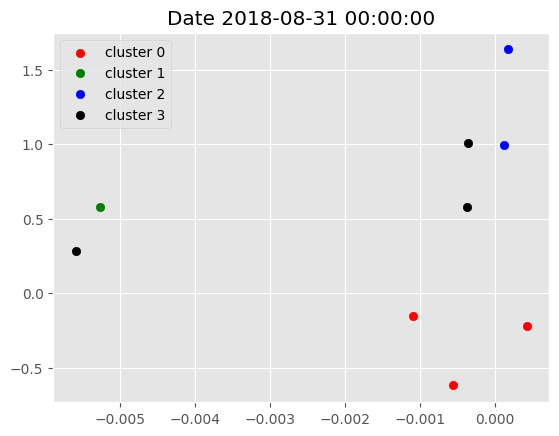

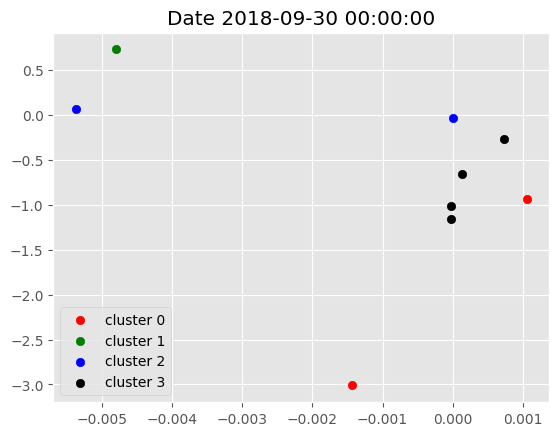

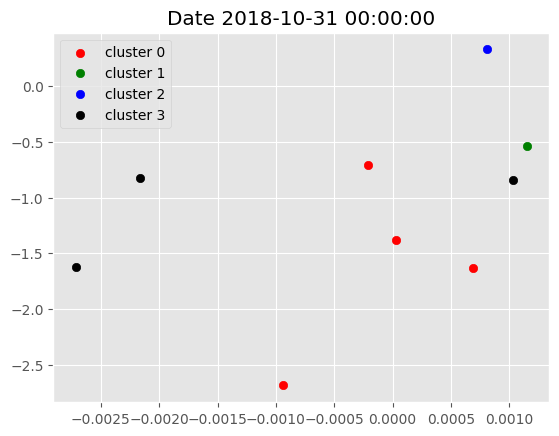

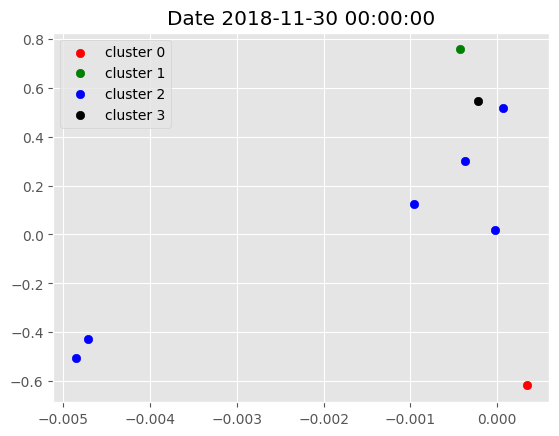

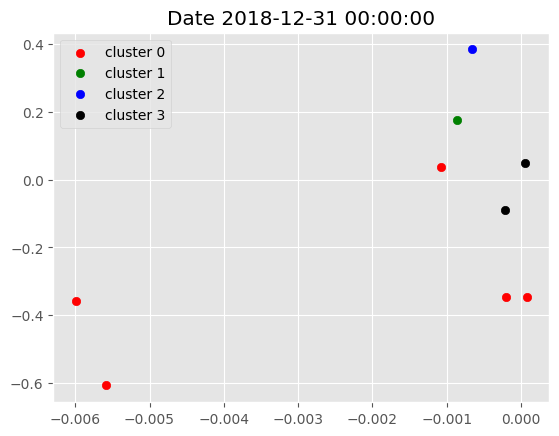

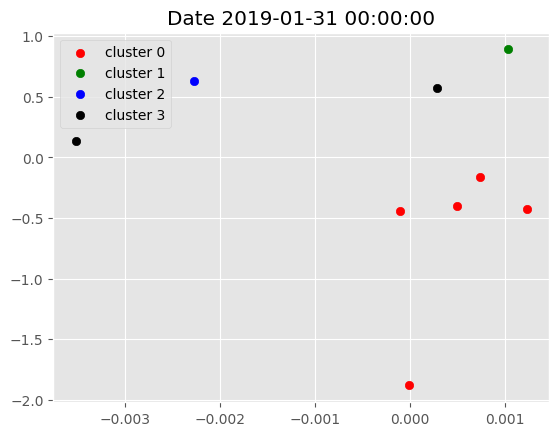

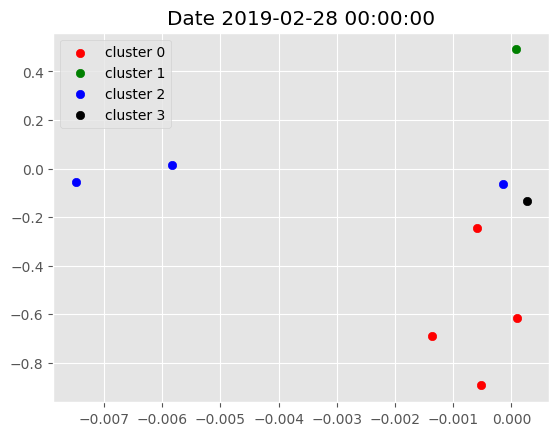

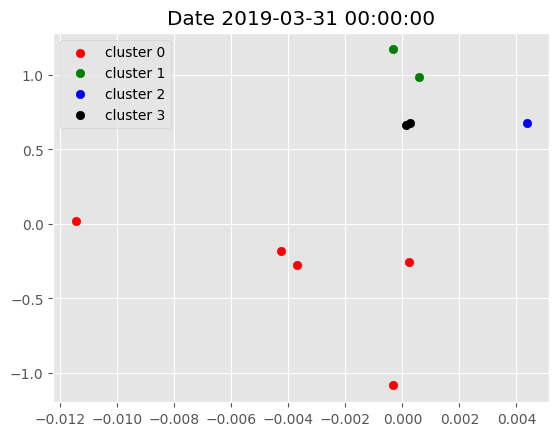

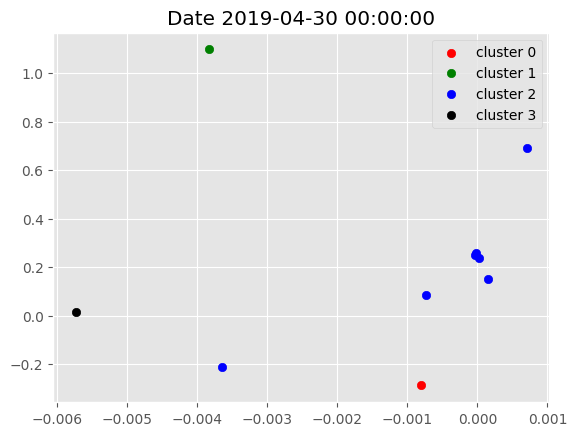

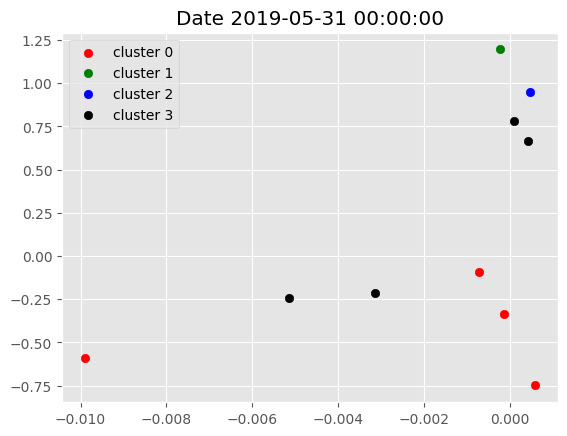

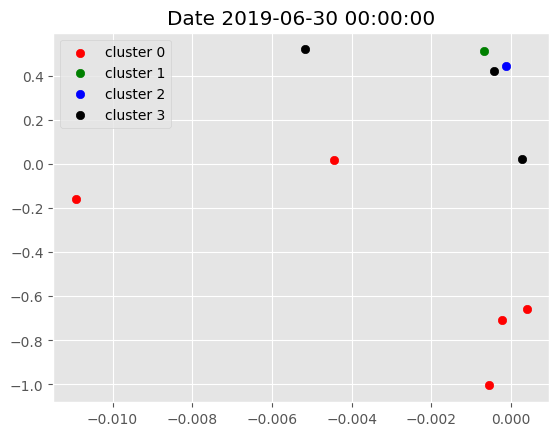

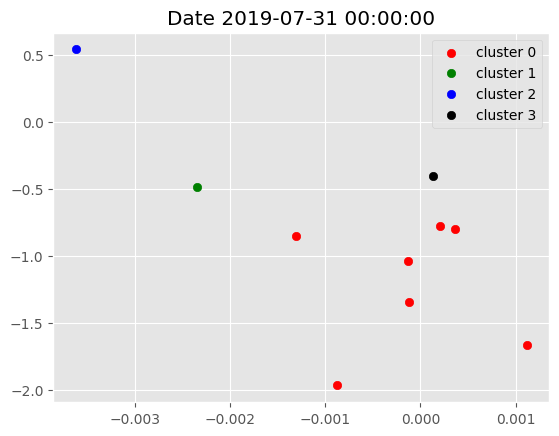

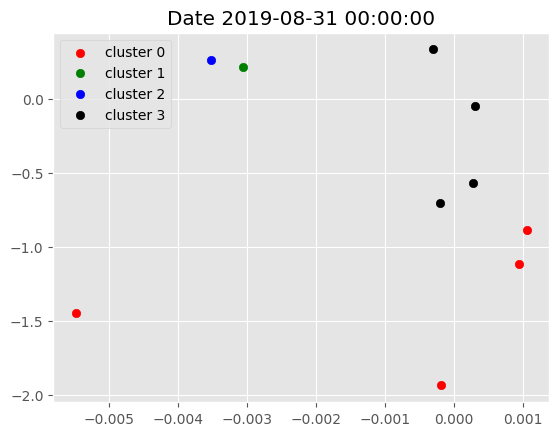

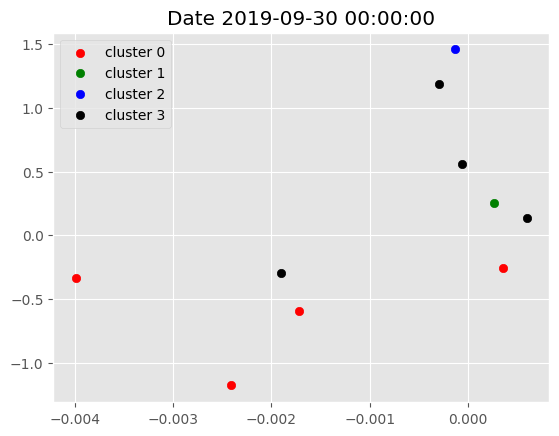

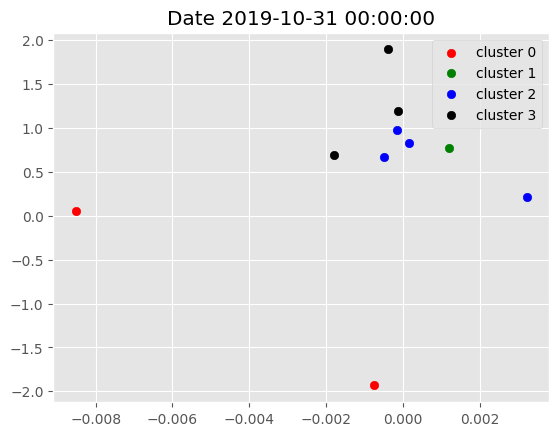

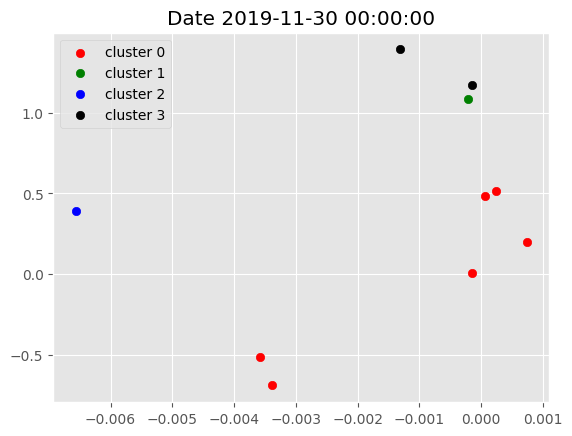

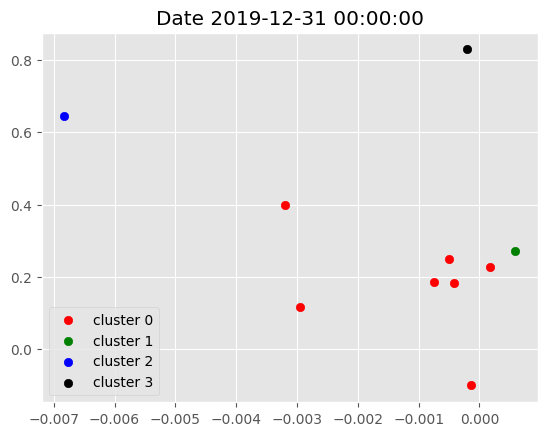

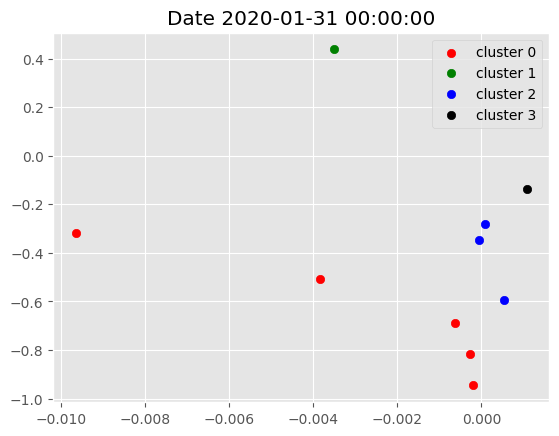

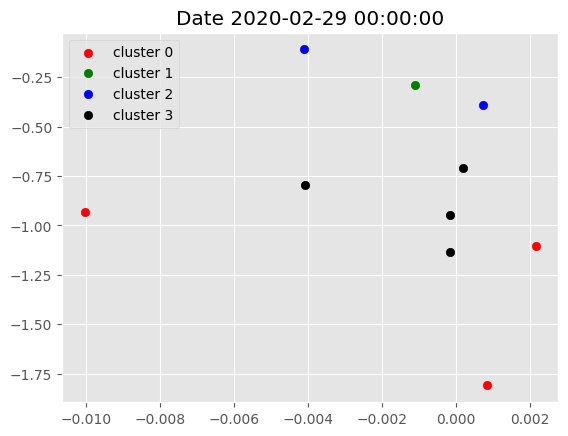

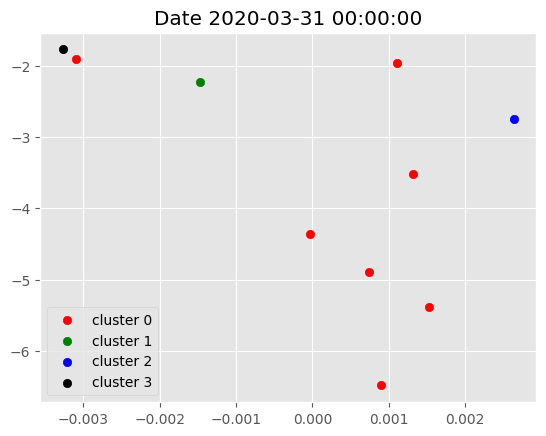

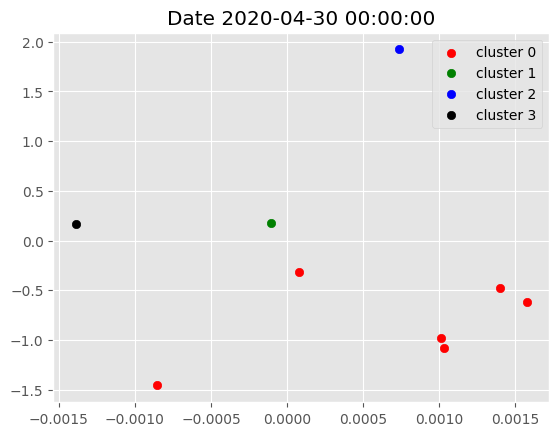

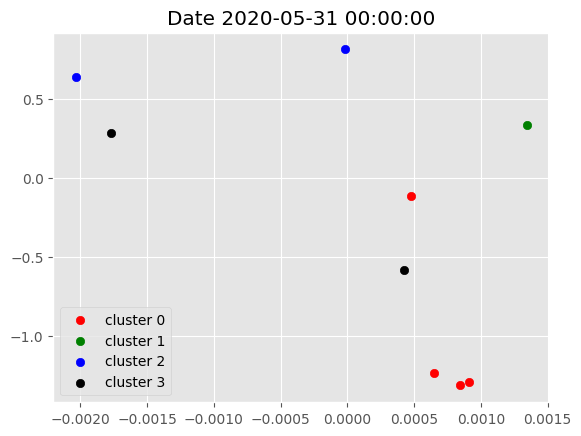

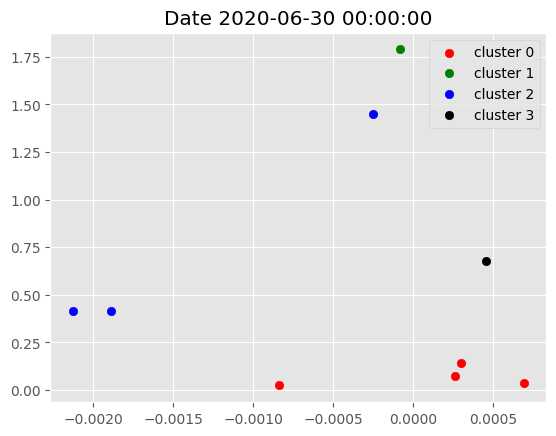

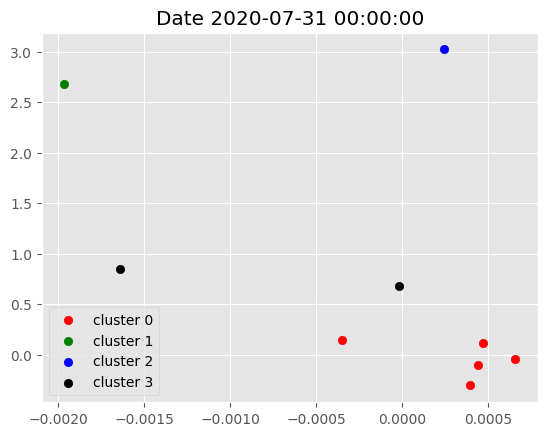

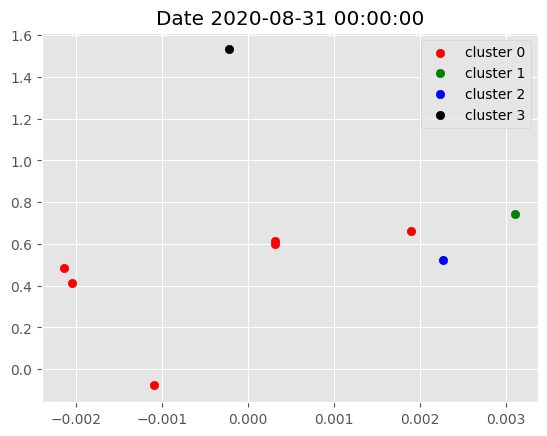

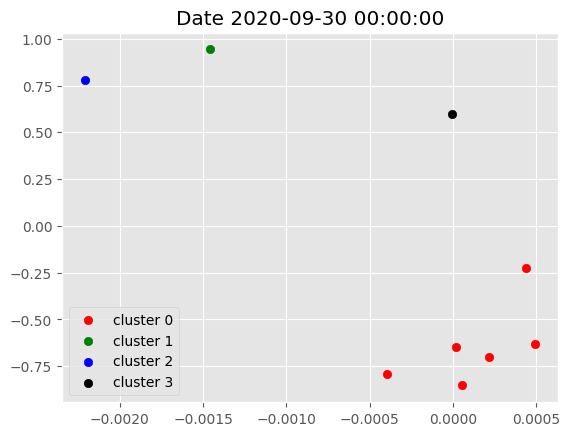

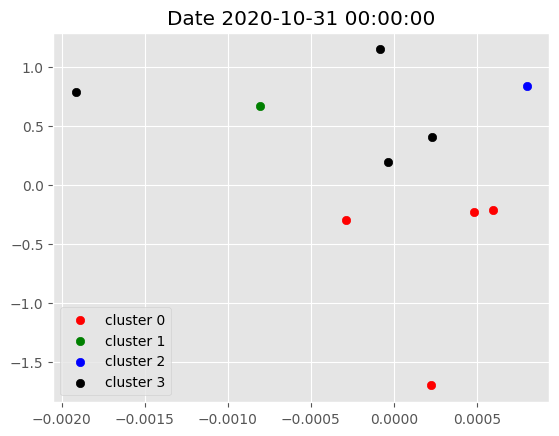

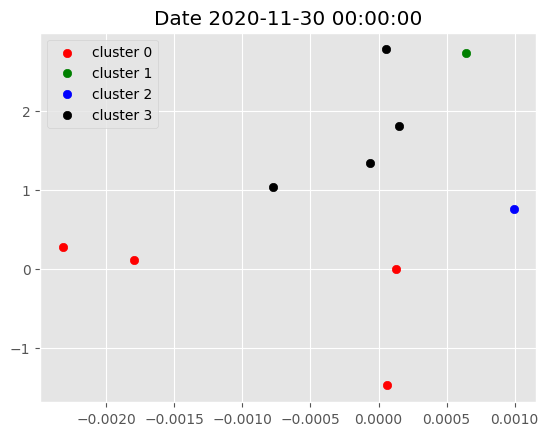

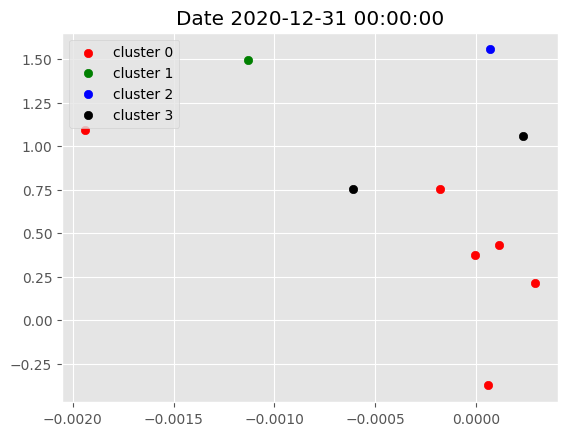

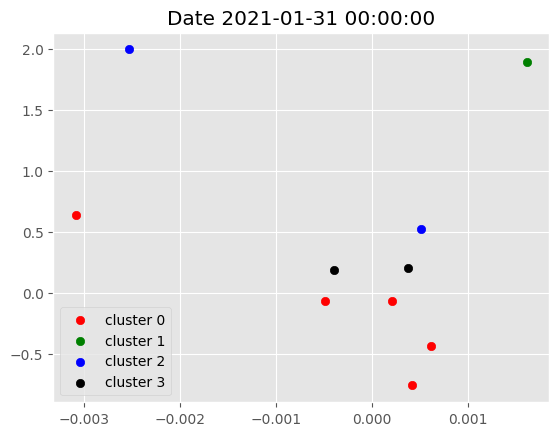

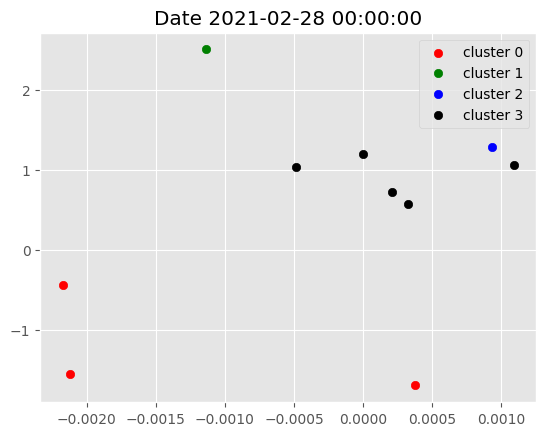

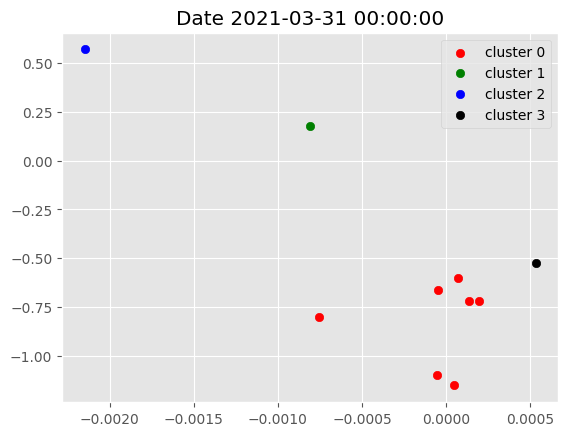

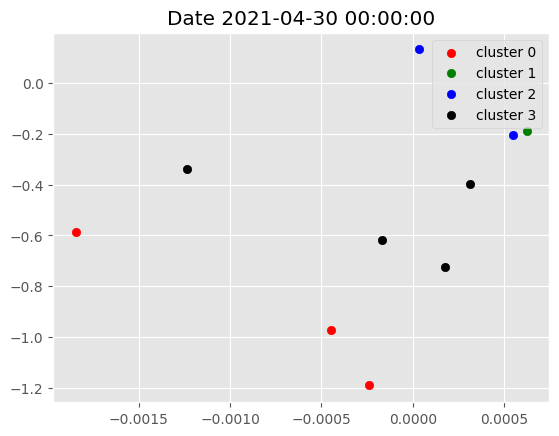

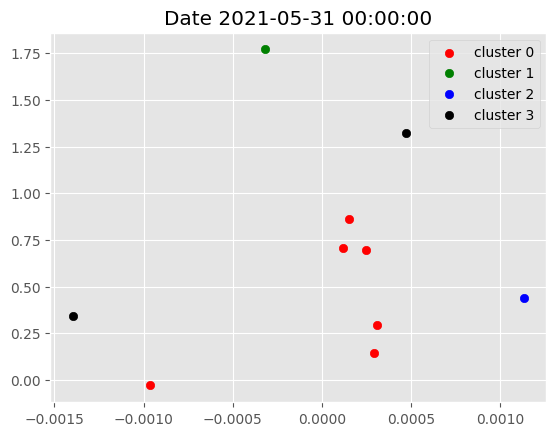

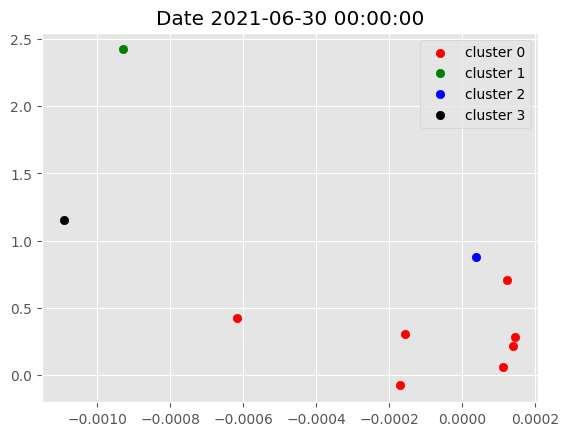

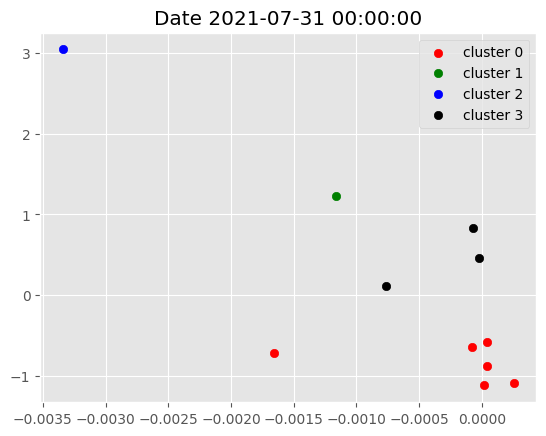

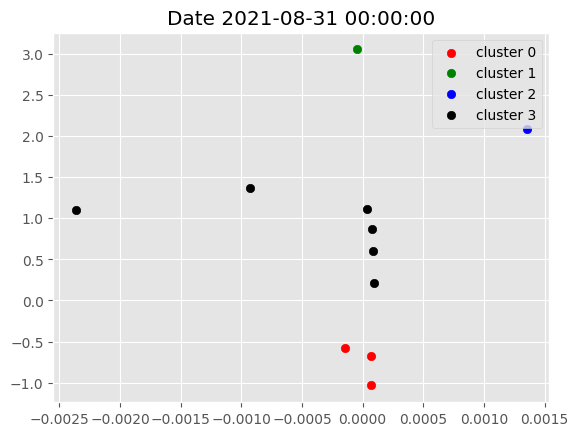

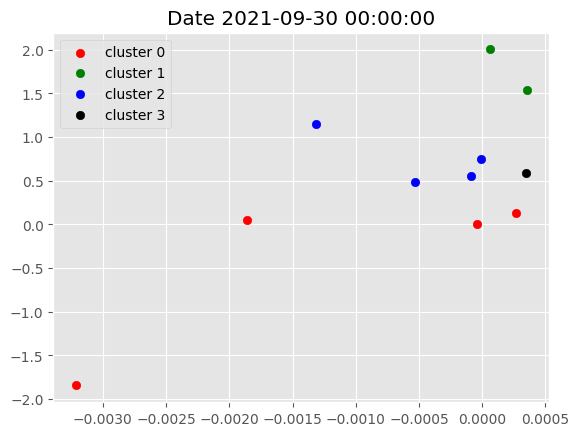

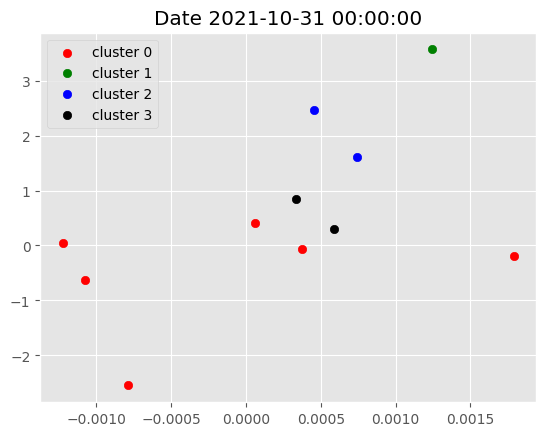

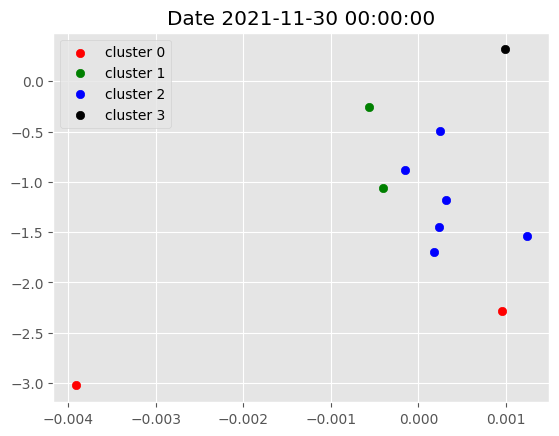

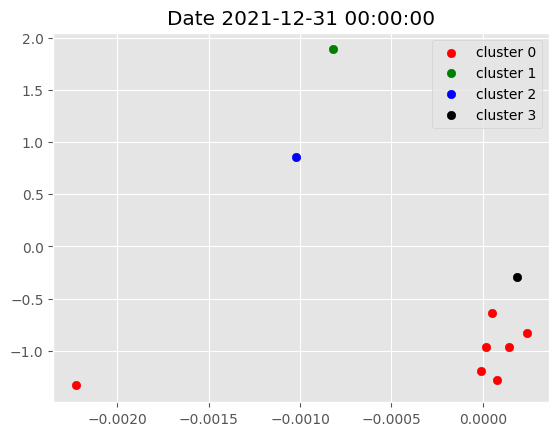

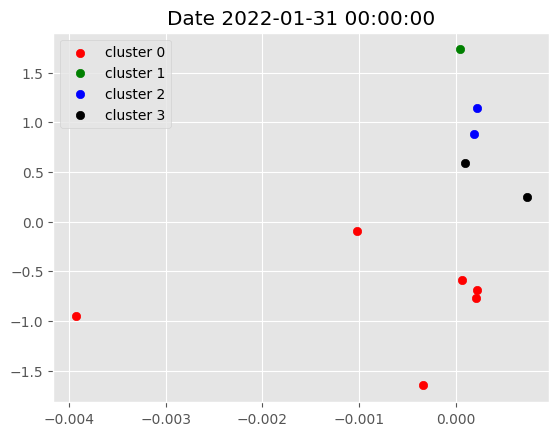

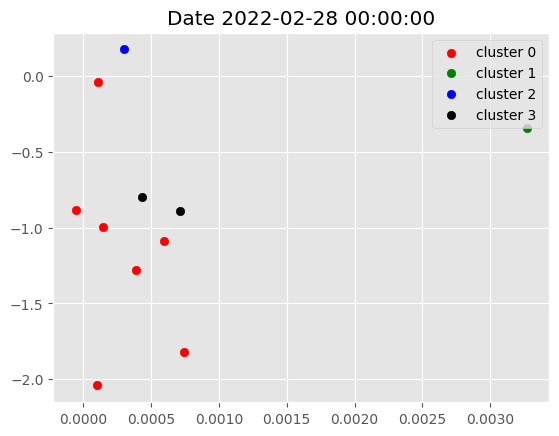

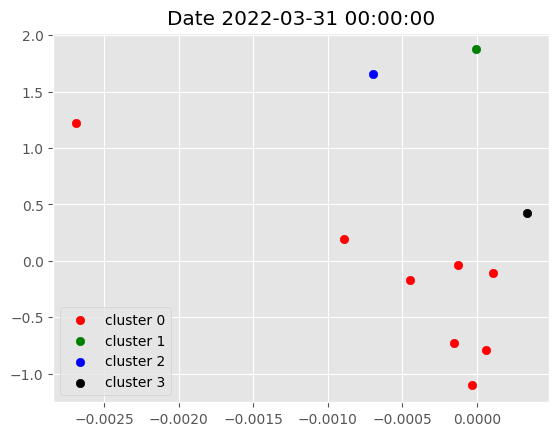

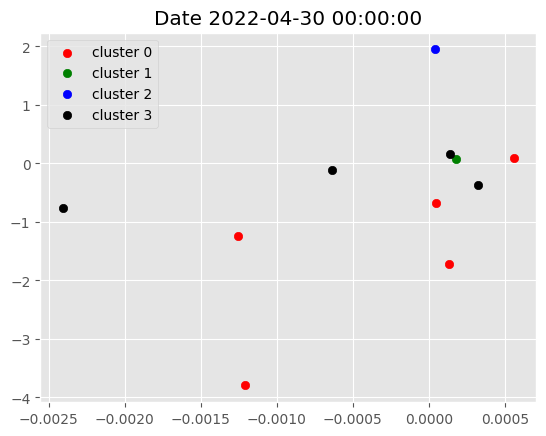

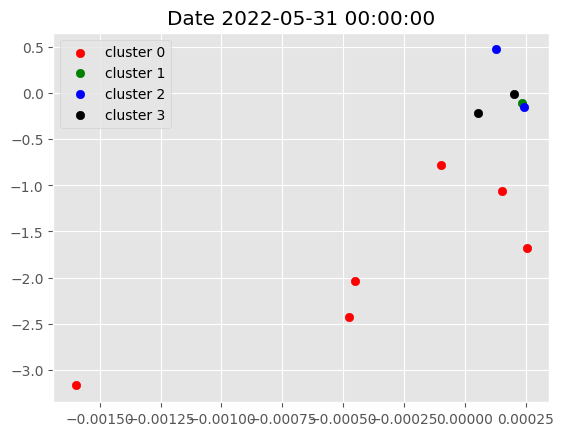

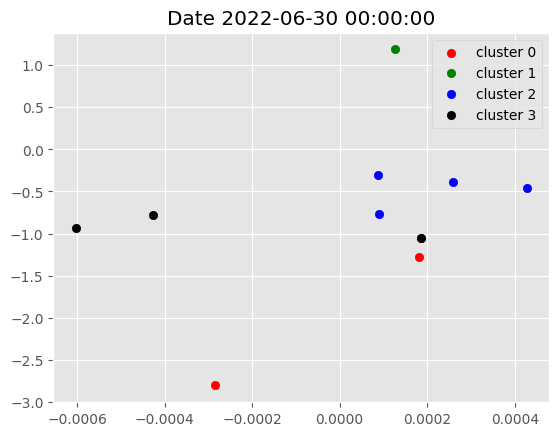

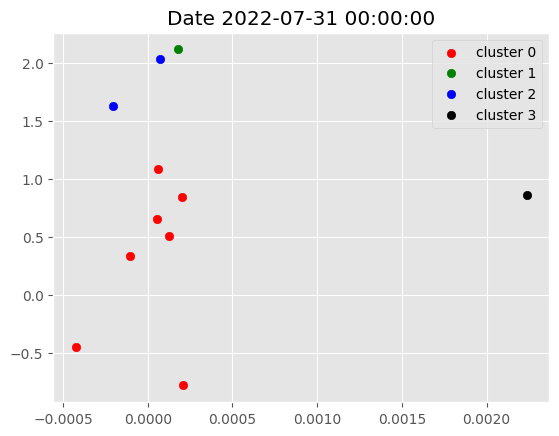

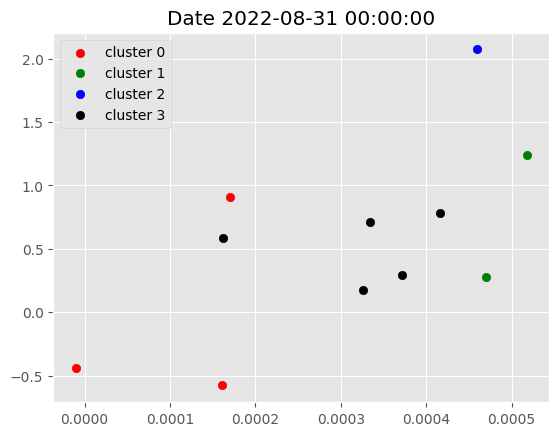

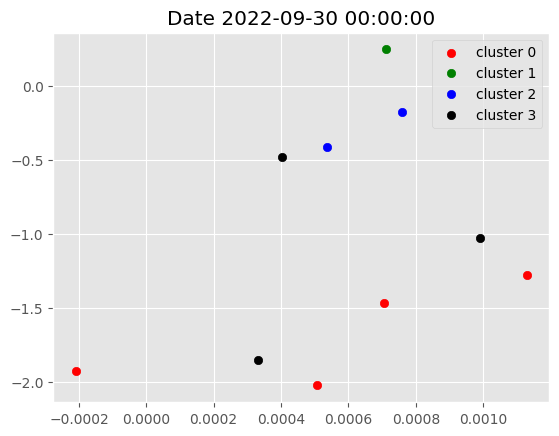

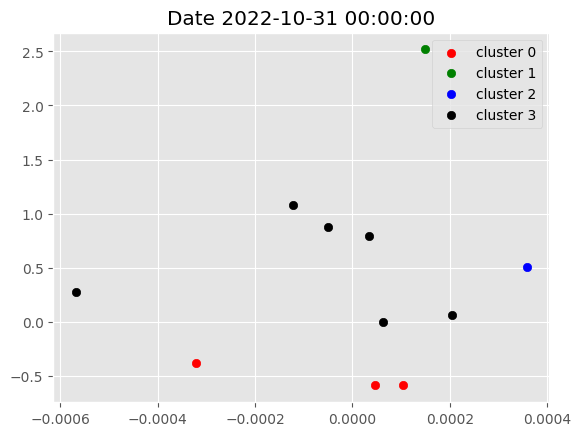

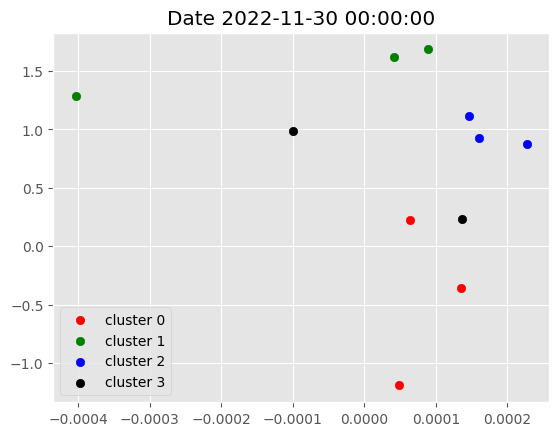

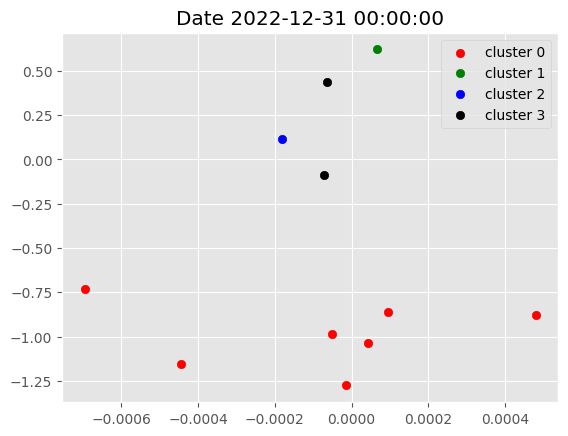

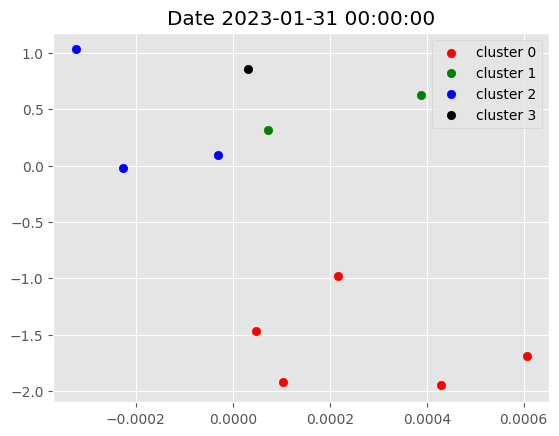

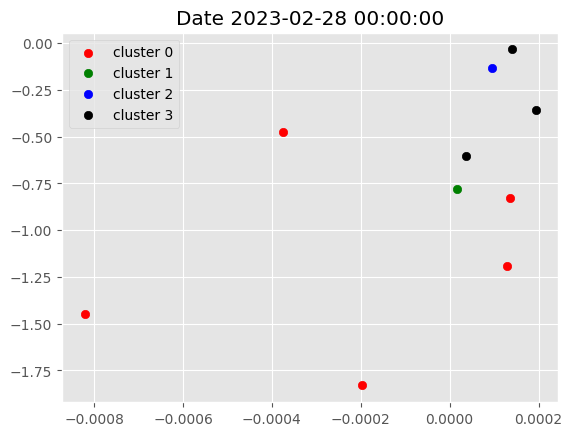

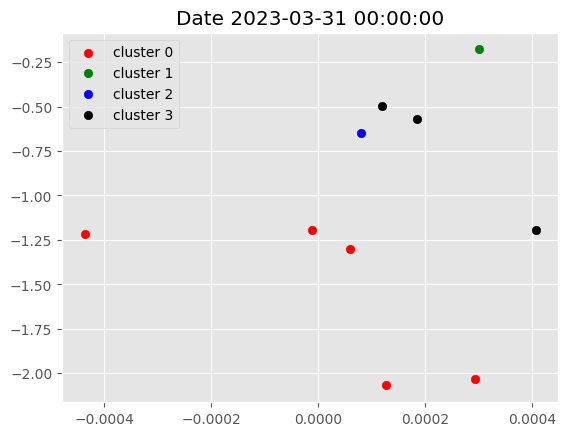

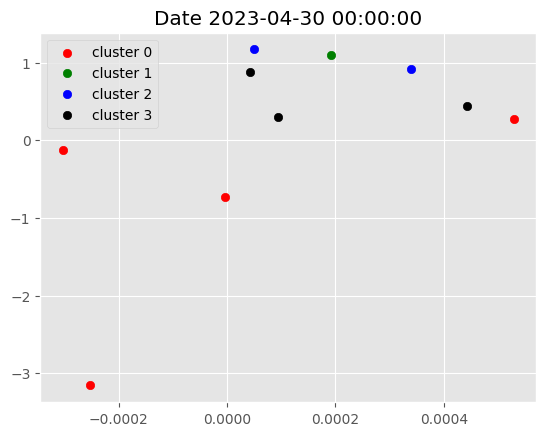

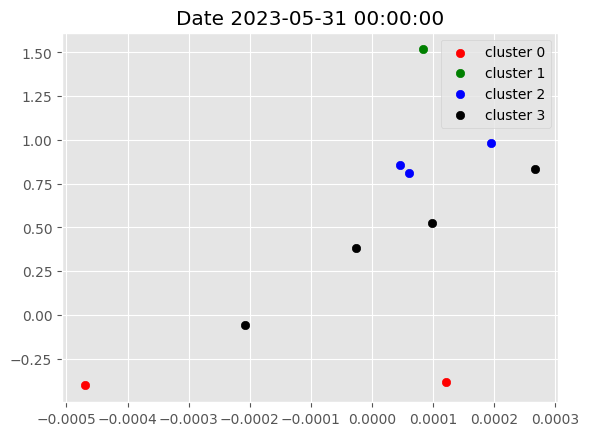

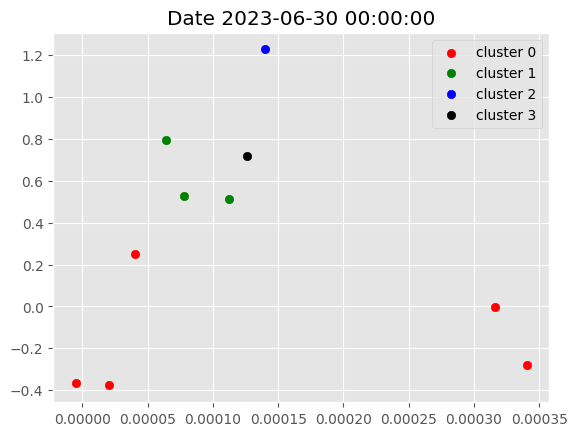

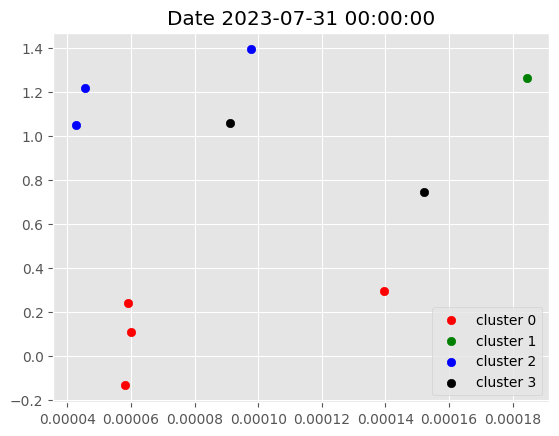

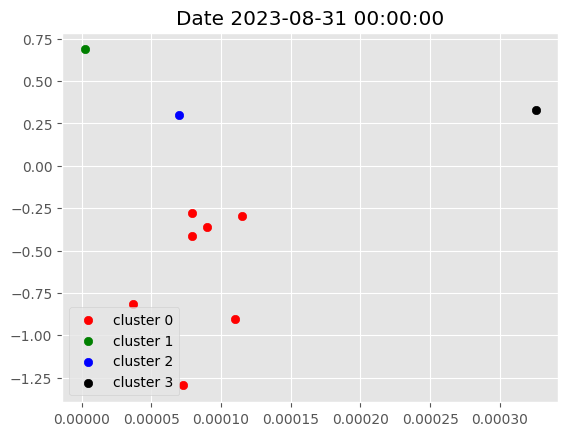

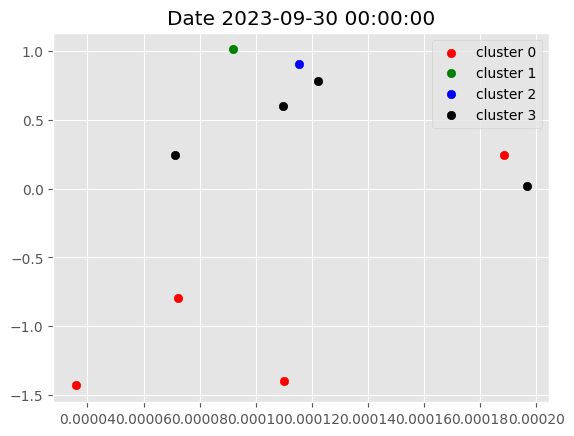

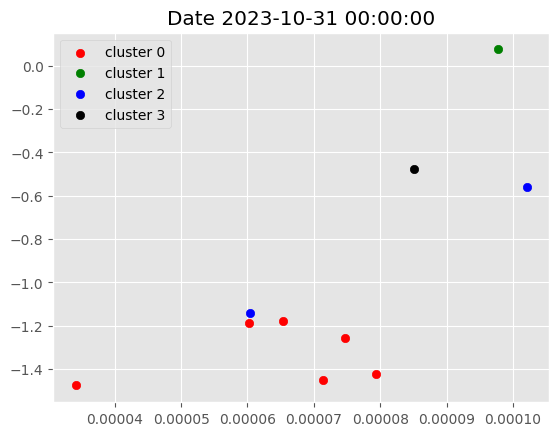

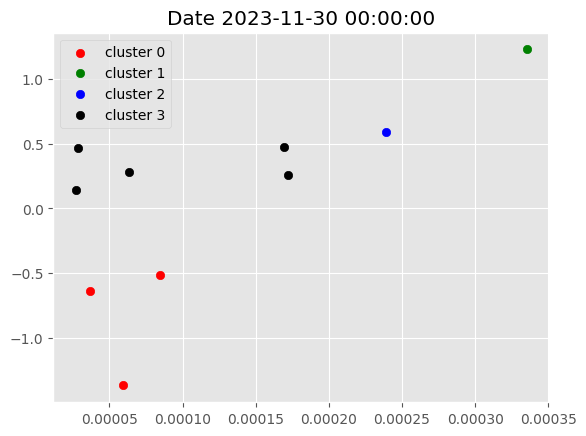

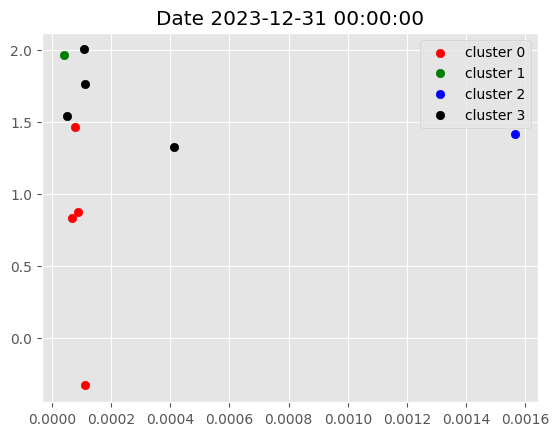

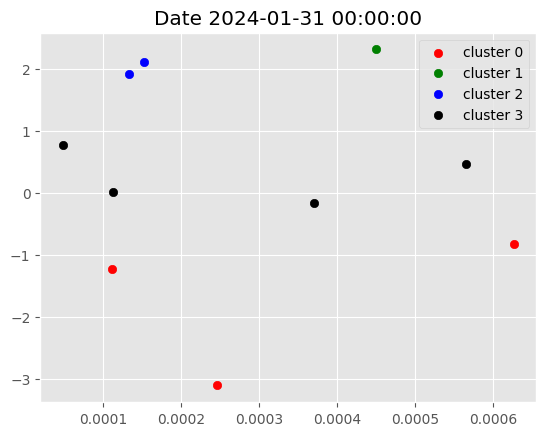

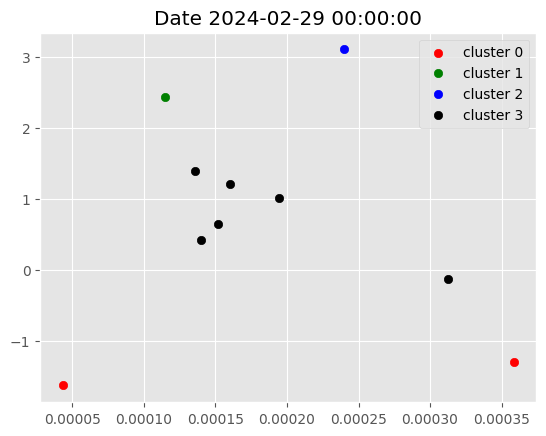

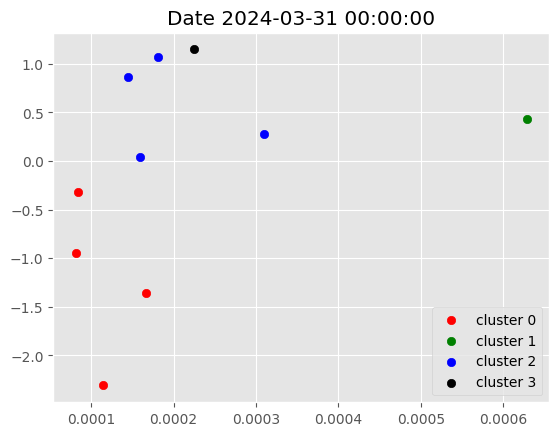

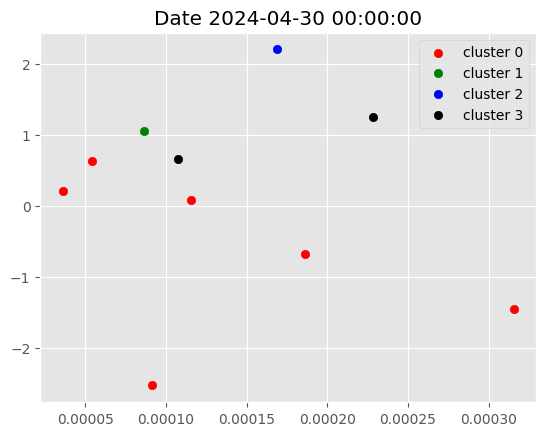

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [14]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-05-01': ['HDFCBANK.NS', 'RELIANCE.NS'],
 '2018-06-01': ['AXISBANK.NS', 'TCS.NS'],
 '2018-07-01': ['HDFCBANK.NS'],
 '2018-08-01': ['AXISBANK.NS',
  'HDFCBANK.NS',
  'INFY.NS',
  'MARUTI.NS',
  'TCS.NS'],
 '2018-09-01': ['INFY.NS', 'RELIANCE.NS', 'SBIN.NS'],
 '2018-10-01': ['AXISBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'SBIN.NS'],
 '2018-11-01': ['AXISBANK.NS', 'INFY.NS', 'TCS.NS'],
 '2018-12-01': ['MARUTI.NS'],
 '2019-01-01': ['AXISBANK.NS', 'ICICIBANK.NS'],
 '2019-02-01': ['RELIANCE.NS', 'TCS.NS'],
 '2019-03-01': ['TATAMOTORS.NS'],
 '2019-04-01': ['ICICIBANK.NS', 'RELIANCE.NS'],
 '2019-05-01': ['TATASTEEL.NS'],
 '2019-06-01': ['HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS'],
 '2019-07-01': ['AXISBANK.NS', 'HDFCBANK.NS', 'TCS.NS'],
 '2019-08-01': ['ICICIBANK.NS'],
 '2019-09-01': ['HDFCBANK.NS', 'ICICIBANK.NS', 'MARUTI.NS', 'RELIANCE.NS'],
 '2019-10-01': ['AXISBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'MARUTI.NS'],
 '2019-11-01': ['MARUTI.NS', 'RELIANCE.NS', 'TCS.NS'],
 '2019-12-01

Define portfolio optimization function
We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

Download Fresh Daily Prices Data only for short listed stocks.


In [16]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  11 of 11 completed


Adj Close                                                       \
            AXISBANK.NS BAJFINANCE.NS  HDFCBANK.NS ICICIBANK.NS      INFY.NS   
Date                                                                           
2017-05-02   498.741394   1246.180054   733.692505   242.695816   388.723663   
2017-05-03   494.104706   1247.653687   735.454651   240.186081   393.653290   
2017-05-04   511.862213   1273.636353   730.930420   262.245331   395.064758   
2017-05-05   497.705505   1251.730347   729.692078   262.905792   392.473541   
2017-05-08   504.315308   1249.520020   730.930420   266.780518   398.372223   
...                 ...           ...          ...          ...          ...   
2024-04-01  1053.099976   7250.950195  1470.500000  1099.650024  1495.449951   
2024-04-02  1047.199951   7207.399902  1480.150024  1081.199951  1482.849976   
2024-04-03  1063.250000   7309.250000  1482.300049  1077.199951  1480.650024   
2024-04-04  1062.949951           NaN          NaN          NaN          NaN   
2024-04-05  1053.750000   7161.950195  1546.099976  1073.400024  1480.000000   

                                                                              \
               MARUTI.NS  RELIANCE.NS     SBIN.NS TATAMOTORS.NS TATASTEEL.NS   
Date                                                                           
2017-05-02   6290.465820   605.085266  273.438538    449.847961    34.940948   
2017-05-03   6232.772461   604.886658  274.861176    445.212402    34.607281   
2017-05-04   6228.832031   599.522522  283.634399    435.143799    34.736824   
2017-05-05   6242.293945   586.410217  280.741577    418.296295    34.042011   
2017-05-08   6220.154297   583.386047  283.966370    421.336823    33.908543   
...                  ...          ...         ...           ...          ...   
2024-04-01  12569.599609  2969.550049  758.299988    992.250000   163.149994   
2024-04-02  12552.450195  2973.899902  766.400024   1004.650024   164.649994   
2024-04-03  12427.849609  2943.199951  771.049988   1009.150024   163.649994   
2024-04-04           NaN          NaN         NaN           NaN          NaN   
2024-04-05  12409.099609  2923.550049  759.500000   1006.900024   163.300003   

            ...        Volume                                                \
            ... BAJFINANCE.NS HDFCBANK.NS ICICIBANK.NS    INFY.NS MARUTI.NS   
Date        ...                                                               
2017-05-02  ...      708574.0   2003520.0   16780204.0  3231126.0  888539.0   
2017-05-03  ...     1086778.0   1253982.0   24205196.0  4659448.0  370021.0   
2017-05-04  ...     1121302.0   2565514.0  122120948.0  5279806.0  372533.0   
2017-05-05  ...      467205.0   1378948.0   48189321.0  4432788.0  337498.0   
2017-05-08  ...      471627.0   1873626.0   30347849.0  4707098.0  208481.0   
...         ...           ...         ...          ...        ...       ...   
2024-04-01  ...     1125238.0  12599785.0   10848191.0  6580002.0  314676.0   
2024-04-02  ...      967615.0  20612723.0   14380396.0  7279400.0  333508.0   
2024-04-03  ...      958943.0  22792193.0   15477184.0  8736248.0  271935.0   
2024-04-04  ...           NaN         NaN          NaN        NaN       NaN   
2024-04-05  ...      825179.0  20922689.0   10840501.0  2838234.0  126729.0   

                                                                          
           RELIANCE.NS     SBIN.NS TATAMOTORS.NS TATASTEEL.NS     TCS.NS  
Date                                                                      
2017-05-02   9295705.0   9754789.0     6071958.0   49217735.0  2382696.0  
2017-05-03   4750019.0  13950914.0     5158586.0   52572996.0  3514406.0  
2017-05-04   7182967.0  24534923.0     6204022.0   68599439.0  2708208.0  
2017-05-05   7799224.0  34756331.0     9487539.0   59847399.0  1682474.0  
2017-05-08   8033366.0  11560550.0     7427873.0   57892409.0  1071782.0  
...                ...         ...           ...          ...    

Calculate daily returns for each stock which could land up in our portfolio.

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculated each day portfolio return.

In [17]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'


""


8. Visualize Portfolio returns and compare to nifty returns.


In [18]:
nft = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nft_ret = np.log(nft[['Adj Close']]).diff().dropna().rename({'Adj Close':'NIFTY  50 Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nft_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,NIFTY 50 Buy&Hold


In [19]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[: end_date ].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

TypeError: cannot do slice indexing on RangeIndex with these indexers [2024-05-31] of type str